In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import multiprocessing

multiprocessing.cpu_count()

2

In [3]:
!pip install pyspark geopandas yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 60.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=5b366447dba2bda80028a0bd1c57d29d6cde015d510089c15ef06f26db9e433f
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [4]:
import numpy as np
import math
from sklearn.cluster import KMeans, kmeans_plusplus
from sklearn.neighbors import KDTree
from shapely.geometry import Polygon
import geopandas as gpd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.datasets import make_blobs, make_moons
import time
from sklearn import metrics
from PIL import Image
from yellowbrick.cluster.elbow import kelbow_visualizer

In [5]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("part2") \
    .getOrCreate()

sc = spark.sparkContext

# K-means Clustering

In [6]:
def compute_labels(points, centroids, return_time=False):
    timestamp = time.time()

    n = len(points)
    k = len(centroids)

    labels = np.zeros(n, dtype=int)

    for i in range(n):
        min_distance = math.inf

        for j in range(k):
            current_distance = np.linalg.norm(points[i] - centroids[j])

            if current_distance < min_distance:
                min_distance = current_distance
                cluster_label = j

        labels[i] = cluster_label

    elapsed_time = time.time() - timestamp

    if return_time:
        return labels, elapsed_time

    return labels

In [7]:
def k_means_pp(points, k, return_time=False):
    timestamp = time.time()

    centroids, _ = kmeans_plusplus(points, k, random_state=12)

    elapsed_time = time.time() - timestamp

    if return_time:
        return centroids, elapsed_time

    return centroids

In [8]:
def k_means_clustering(points, k, return_time=False):
    timestamp = time.time()

    k_means = KMeans(k, random_state=12).fit(points)

    centroids = k_means.cluster_centers_
    labels = k_means.labels_

    elapsed_time = time.time() - timestamp

    if return_time:
        return centroids, labels, elapsed_time

    return centroids, labels

# Coreset Construction

In [9]:
def cost(points, centroids):
    n = len(points)
    k = len(centroids)

    min_squared_distances = np.full(n, np.inf)

    for i in range(n):
        for j in range(k):
            x = np.linalg.norm(points[i] - centroids[j]) ** 2

            if min_squared_distances[i] > x:
                min_squared_distances[i] = x
    
    return np.sum(min_squared_distances)

In [10]:
def coreset_construction(points, k, epsilon, return_time=False):
    timestamp = time.time()

    n = len(points)
    d = points.shape[1]
    a = 12
    z = math.ceil(math.log(n) * math.log(a * math.log(n)))

    coreset = []

    centroids = k_means_pp(points, k)

    r = math.sqrt(cost(points, centroids) / (a * math.log(n) * n))

    points_copy = points.copy() # copy the points to a new array to keep track of what already covered

    for i in range(z):
        for j in range(k):
            if len(points_copy) == 0: # stop when all points are covered
                return np.array(coreset)

            radius = (2 ** i) * r

            # find all points lie within the radius from the current centroid
            kd_tree = KDTree(points_copy)
            indices = kd_tree.query_radius(centroids[j].reshape(1, -1), r=radius)[0]
            points_within_radius = points_copy[indices]

            points_copy = np.delete(points_copy, indices, axis=0) # delete points we are considering, so that in the next iteration, only points on the annulus are considered

            x = (epsilon * radius) / math.sqrt(d)

            grid = []

            # calculate the coordinates of the bottom left point of the grid
            xy = centroids[j] - ((1 / 2 + math.ceil(math.sqrt(d) / epsilon - 1 / 2)) * x)
            xy_copy = xy.copy()

            # construct the grid with square cells of width x
            for row in range(math.ceil(2 * math.sqrt(d) / epsilon)):
                xy_copy[1] = xy[1] + row * x

                for col in range(math.ceil(2 * math.sqrt(d) / epsilon)):
                    xy_copy[0] = xy[0] + col * x

                    grid.append(Polygon([(xy_copy[0], xy_copy[1]), (xy_copy[0], xy_copy[1] + x), (xy_copy[0] + x, xy_copy[1] + x), (xy_copy[0] + x, xy_copy[1])])) # one cell as a polygon of 4 points

            # convert to geopandas df
            points_gpd = gpd.GeoDataFrame(geometry=gpd.points_from_xy(points_within_radius[:, 0], points_within_radius[:, 1]))
            grid_gpd = gpd.GeoDataFrame(geometry=grid)

            # aggregate the grid and points to find point-in-polygon
            cells_contains = gpd.sjoin(grid_gpd, points_gpd, predicate='contains')
            cells_contains['id'] = cells_contains.index
            cells_contains['point'] = points_within_radius[cells_contains['index_right']].tolist()

            # take the first point in each polygon
            cells_contains = cells_contains.groupby('id').first()

            coreset += cells_contains['point'].to_list()

    elapsed_time = time.time() - timestamp

    if return_time:
        return np.array(coreset), elapsed_time

    return np.array(coreset)

# MPC for Coreset Construction

In [11]:
def coreset_construction_mpc(points, k, epsilon, num_partitions=8, return_time=False):
    points_rdd = sc.parallelize(points, num_partitions) # distribute the points to a number of partitions for parallel processing

    timestamp = time.time()

    # apply coreset_construction to the subsets of points within each partition
    coreset = points_rdd \
        .mapPartitions(lambda points_iter: coreset_construction(np.array(list(points_iter)), k, epsilon))

    i = 0

    # reduce the number of partitions by half and apply coreset_construction until only one partition left
    while num_partitions != 1:
        num_partitions //= 2
        i += 1
        epsilon /= 4 * i

        coreset = coreset \
            .coalesce(num_partitions) \
            .mapPartitions(lambda points_iter: coreset_construction(np.array(list(points_iter)), k, epsilon)) \

    coreset = np.array(coreset.collect())

    elapsed_time = time.time() - timestamp

    if return_time:
        return coreset, elapsed_time

    return coreset

# Misc

In [12]:
def plot_clusters(ax, points, centroids=None, labels=None):
    if centroids is not None:
        ax.scatter(centroids[:, 0], centroids[:, 1], s=50, c='k', marker='x', zorder=10, label='Centroid')

    if labels is None:
        ax.scatter(points[:, 0], points[:, 1], s=10, alpha=0.6)
    else:
        cluster_labels = np.unique(labels)
        num_clusters = len(cluster_labels)

        colors = iter(cm.rainbow(np.linspace(0, 1, num_clusters)))

        for label in cluster_labels:
            indices = np.where(labels == label)

            ax.scatter(points[indices, 0], points[indices, 1], s=10, alpha=0.6, color=next(colors), label=f'Cluster {label}')

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Demo

In [ ]:
X, y, centroids = make_blobs(n_samples=100000, centers=3, shuffle=False, random_state=12, return_centers=True)

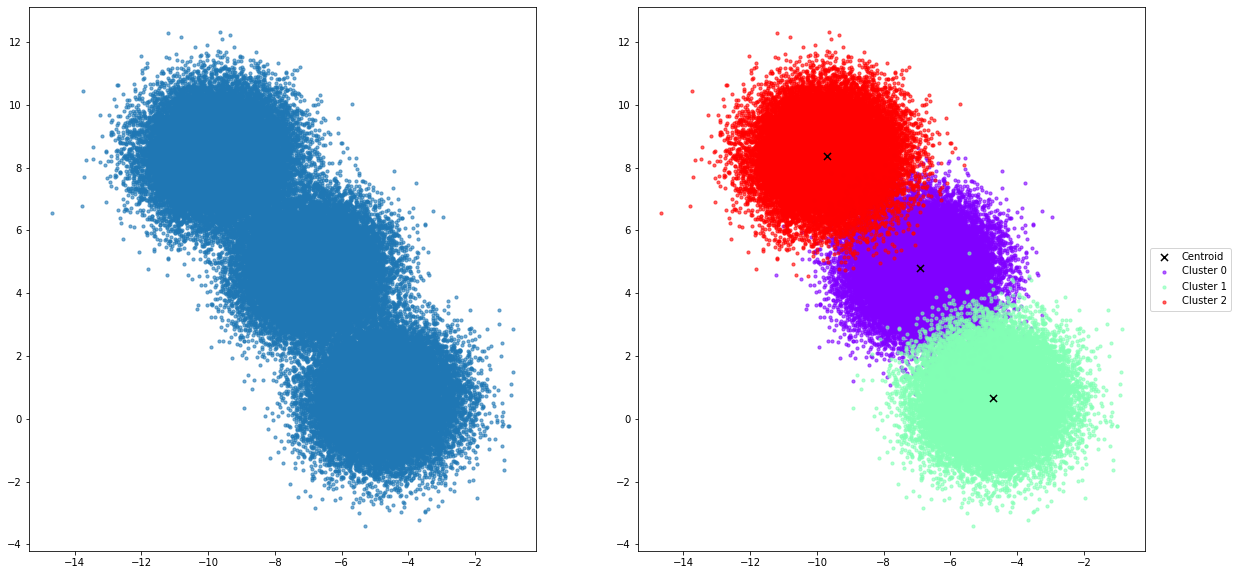

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_clusters(axes[0], X)
plot_clusters(axes[1], X, centroids=centroids, labels=y)
plt.show()

## Coreset Construction

In [ ]:
coreset = coreset_construction(X, 3, 0.1)
print(coreset.shape)

(7191, 2)


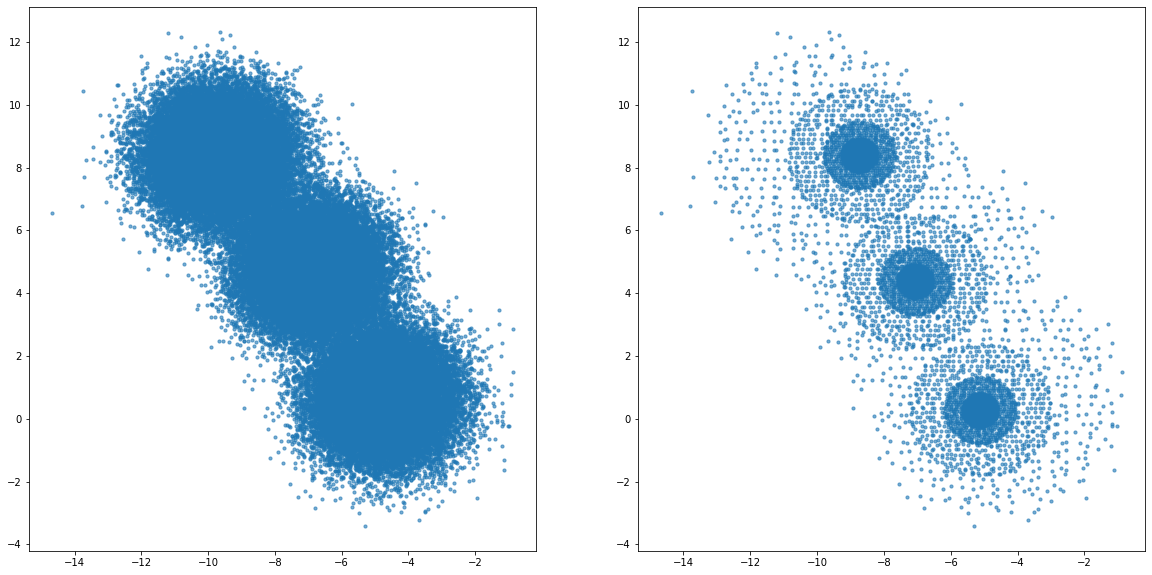

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_clusters(axes[0], X)
plot_clusters(axes[1], coreset)
plt.show()

In [ ]:
centroids_hat, y_hat = k_means_clustering(coreset, 3)

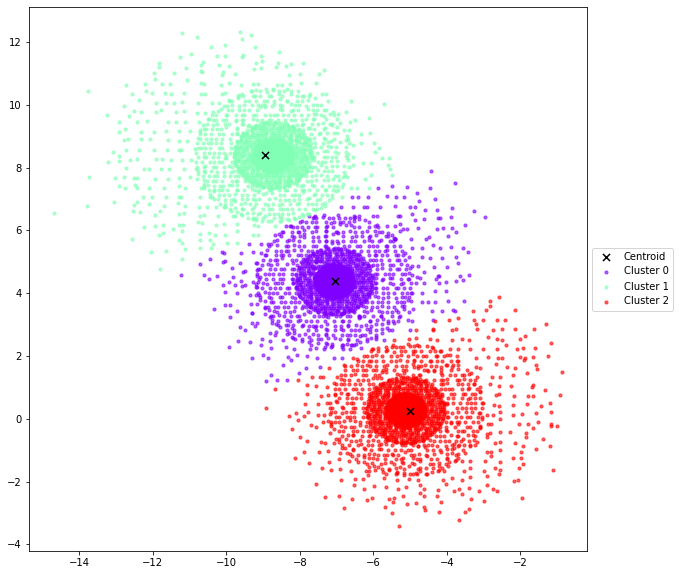

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_clusters(ax, coreset, centroids=centroids_hat, labels=y_hat)
plt.show()

In [ ]:
y_hat = compute_labels(X, centroids_hat)

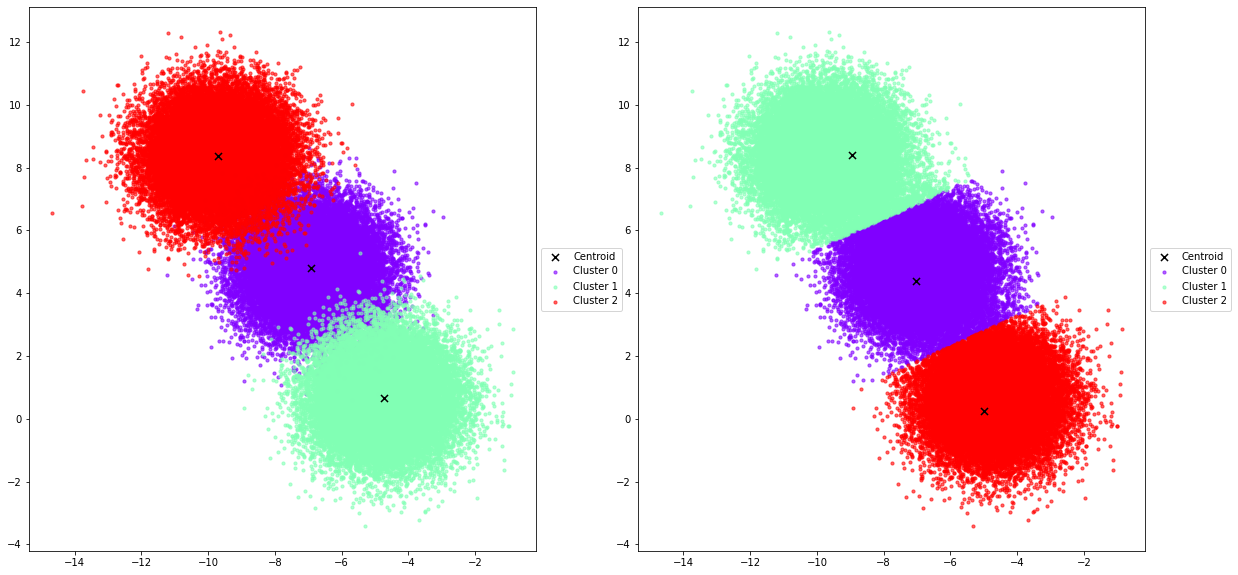

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_clusters(axes[0], X, centroids=centroids, labels=y)
plot_clusters(axes[1], X, centroids=centroids_hat, labels=y_hat)
plt.show()

## MPC

In [ ]:
coreset_mpc = coreset_construction_mpc(X, 3, 0.1, num_partitions=2)
print(coreset_mpc.shape)

(29953, 2)


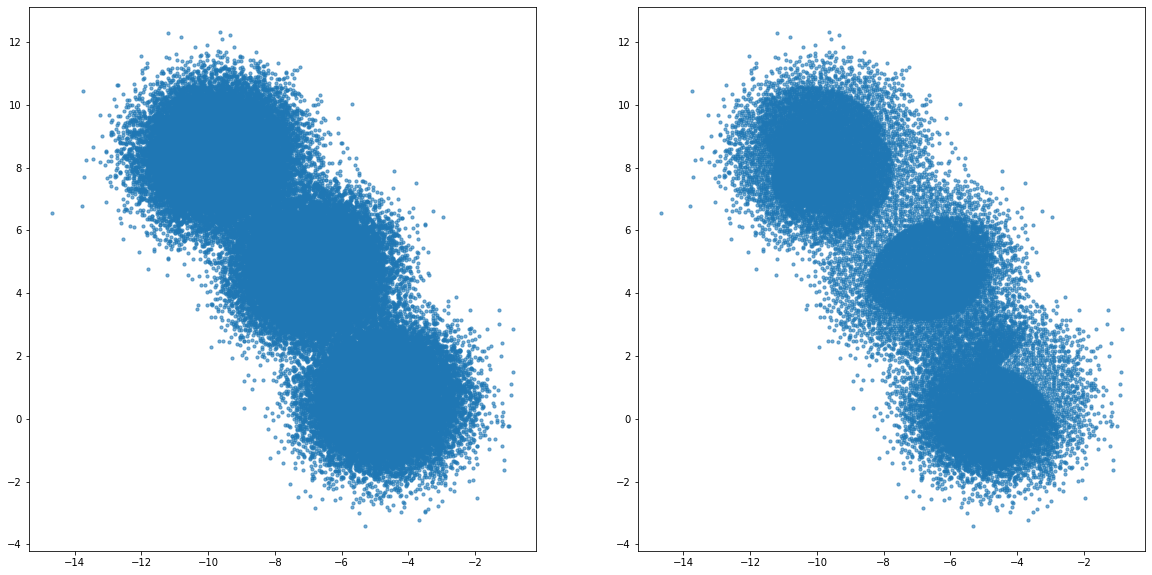

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_clusters(axes[0], X)
plot_clusters(axes[1], coreset_mpc)
plt.show()

In [ ]:
centroids_mpc_hat, y_mpc_hat = k_means_clustering(coreset_mpc, 3)

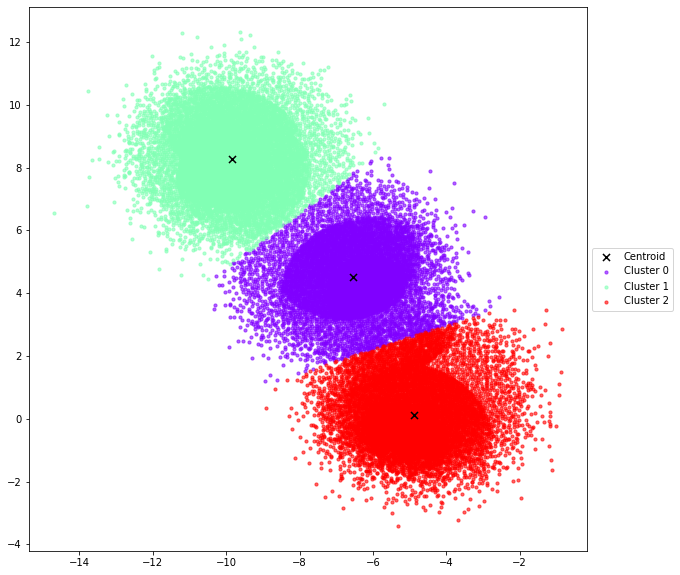

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_clusters(ax, coreset_mpc, centroids=centroids_mpc_hat, labels=y_mpc_hat)
plt.show()

In [ ]:
y_mpc_hat = compute_labels(X, centroids_mpc_hat)

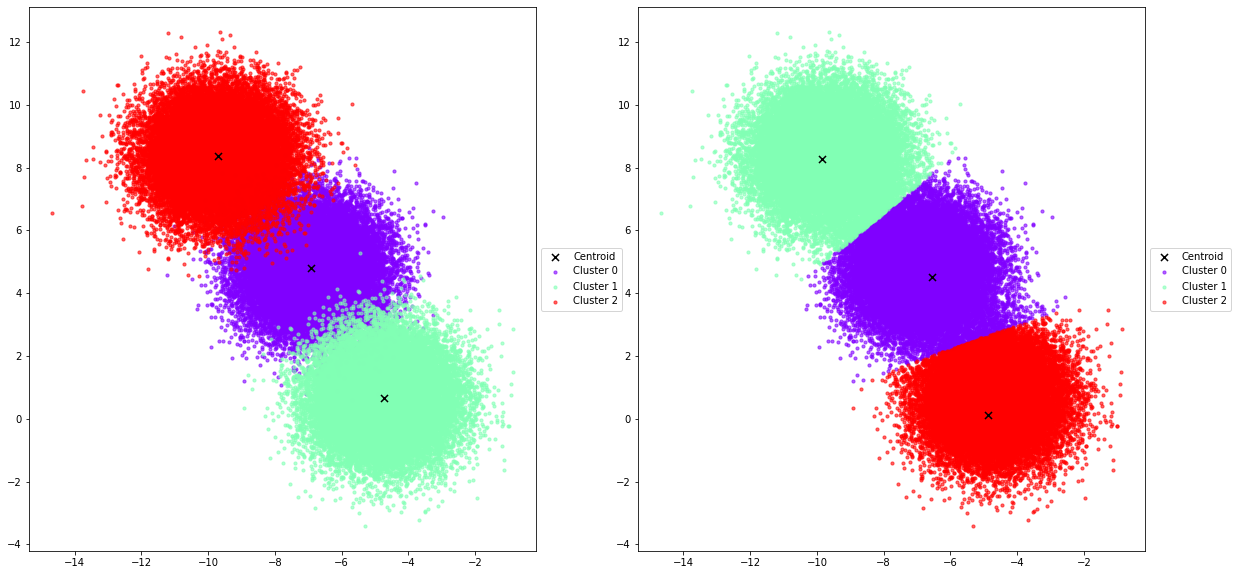

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_clusters(axes[0], X, centroids=centroids, labels=y)
plot_clusters(axes[1], X, centroids=centroids_mpc_hat, labels=y_mpc_hat)
plt.show()

# Experiments

## Number of points

In [ ]:
n_samples = [1000, 10000, 100000, 1000000] # 10000000 takes too long to run

In [ ]:
k_means_only_times = []
k_means_on_coreset_times = []

for n in n_samples:
    X, y = make_blobs(n_samples=n, centers=3, shuffle=False, random_state=12)

    _, _, k_means_only_time = k_means_clustering(X, 3, return_time=True)

    k_means_only_times.append(k_means_only_time)

    coreset, coreset_construction_time = coreset_construction_mpc(X, 3, 0.1, num_partitions=2, return_time=True)
    centroids, _, k_means_on_coreset_time = k_means_clustering(coreset, 3, return_time=True)
    _, compute_labels_time = compute_labels(X, centroids, return_time=True)

    k_means_on_coreset_times.append(coreset_construction_time + k_means_on_coreset_time + compute_labels_time)

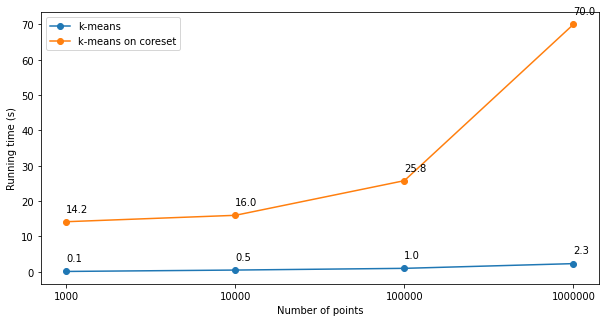

In [ ]:
p = np.arange(3, 7)
n = 10 ** p

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(p, k_means_only_times, marker='o', label='k-means')

for x, y in zip(p, k_means_only_times):
    ax.annotate(round(y, 1), (x, y), textcoords="offset points", xytext=(0, 10))

ax.plot(p, k_means_on_coreset_times, marker='o', label='k-means on coreset')

for x, y in zip(p, k_means_on_coreset_times):
    ax.annotate(round(y, 1), (x, y), textcoords="offset points", xytext=(0, 10))

ax.set_xlabel('Number of points')
ax.set_ylabel('Running time (s)')
ax.set_xticks(p)
ax.set_xticklabels(n)
ax.legend()

plt.show()

## Blobs

In [ ]:
n = 1000000
k = 3
cluster_stds = [0.5, 0.7, 1.0]
epsilons = [0.1, 0.25, 0.5, 0.75, 1.0]

In [ ]:
for cluster_std in cluster_stds:
    X, y, centroids = make_blobs(n_samples=n, centers=k, cluster_std=cluster_std, shuffle=False, random_state=12, return_centers=True)

    coreset_sizes = []
    running_times = []
    scores = []

    for epsilon in epsilons:
        coreset, coreset_construction_time = coreset_construction_mpc(X, k, epsilon, num_partitions=2, return_time=True)
        centroids_hat, _, k_means_on_coreset_time = k_means_clustering(coreset, k, return_time=True)
        y_hat, compute_labels_time = compute_labels(X, centroids_hat, return_time=True)

        coreset_sizes.append(len(coreset))
        running_times.append(coreset_construction_time + k_means_on_coreset_time + compute_labels_time)

        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        plot_clusters(axes[0], X, centroids=centroids, labels=y)
        axes[0].set_title('Ground truth')
        plot_clusters(axes[1], X, centroids=centroids_hat, labels=y_hat)
        axes[1].set_title('k-means on coreset result')
        fig.suptitle(f"n_samples={n}, n_clusters={k}, cluster_std={cluster_std}, epsilon={epsilon}", fontsize=16)
        plt.show()

        score = metrics.adjusted_rand_score(y, y_hat)
        scores.append(score)

        print(f"Adjusted Rand Index: {score}")

    fig, axes = plt.subplots(3, figsize=(10, 15))

    axes[0].plot(epsilons, coreset_sizes, marker='o')
    axes[0].set_xlabel('epsilon')
    axes[0].set_ylabel('Coreset size')
    axes[0].set_xticks(epsilons)

    for x, y in zip(epsilons, coreset_sizes):
        axes[0].annotate(y, (x, y), textcoords="offset points", xytext=(0, 10))

    axes[1].plot(epsilons, running_times, marker='o')
    axes[1].set_xlabel('epsilon')
    axes[1].set_ylabel('Running time (s)')
    axes[1].set_xticks(epsilons)

    for x, y in zip(epsilons, running_times):
        axes[1].annotate(round(y, 1), (x, y), textcoords="offset points", xytext=(0, 10))

    axes[2].plot(epsilons, scores, marker='o')
    axes[2].set_xlabel('epsilon')
    axes[2].set_ylabel('Adjusted Rand Index')
    axes[2].set_xticks(epsilons)

    for x, y in zip(epsilons, scores):
        axes[2].annotate(round(y, 2), (x, y), textcoords="offset points", xytext=(0, 10))

    fig.suptitle(f"n_samples={n}, n_clusters={k}, cluster_std={cluster_std}", fontsize=16)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Moons

In [ ]:
n = 1000000
k = 2
noises = [0.05, 0.1, 0.2]
epsilons = [0.1, 0.25, 0.5, 0.75, 1.0]

In [ ]:
for noise in noises:
    X, y = make_moons(n_samples=n, shuffle=False, noise=noise, random_state=12)

    coreset_sizes = []
    running_times = []
    scores = []

    for epsilon in epsilons:
        coreset, coreset_construction_time = coreset_construction_mpc(X, k, epsilon, num_partitions=2, return_time=True)
        centroids_hat, _, k_means_on_coreset_time = k_means_clustering(coreset, k, return_time=True)
        y_hat, compute_labels_time = compute_labels(X, centroids_hat, return_time=True)

        coreset_sizes.append(len(coreset))
        running_times.append(coreset_construction_time + k_means_on_coreset_time + compute_labels_time)

        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        plot_clusters(axes[0], X, labels=y)
        axes[0].set_title('Ground truth')
        plot_clusters(axes[1], X, centroids=centroids_hat, labels=y_hat)
        axes[1].set_title('k-means on coreset result')
        fig.suptitle(f"n_samples={n}, n_clusters={k}, noise={noise}, epsilon={epsilon}", fontsize=16)
        plt.show()

        score = metrics.adjusted_rand_score(y, y_hat)
        scores.append(score)

        print(f"Adjusted Rand Index: {score}")

    fig, axes = plt.subplots(3, figsize=(10, 15))

    axes[0].plot(epsilons, coreset_sizes, marker='o')
    axes[0].set_xlabel('epsilon')
    axes[0].set_ylabel('Coreset size')
    axes[0].set_xticks(epsilons)

    for x, y in zip(epsilons, coreset_sizes):
        axes[0].annotate(y, (x, y), textcoords="offset points", xytext=(0, 10))

    axes[1].plot(epsilons, running_times, marker='o')
    axes[1].set_xlabel('epsilon')
    axes[1].set_ylabel('Running time (s)')
    axes[1].set_xticks(epsilons)

    for x, y in zip(epsilons, running_times):
        axes[1].annotate(round(y, 1), (x, y), textcoords="offset points", xytext=(0, 10))

    axes[2].plot(epsilons, scores, marker='o')
    axes[2].set_xlabel('epsilon')
    axes[2].set_ylabel('Adjusted Rand Index')
    axes[2].set_xticks(epsilons)

    for x, y in zip(epsilons, scores):
        axes[2].annotate(round(y, 2), (x, y), textcoords="offset points", xytext=(0, 10))

    fig.suptitle(f"n_samples={n}, n_clusters={k}, noise={noise}", fontsize=16)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Lena

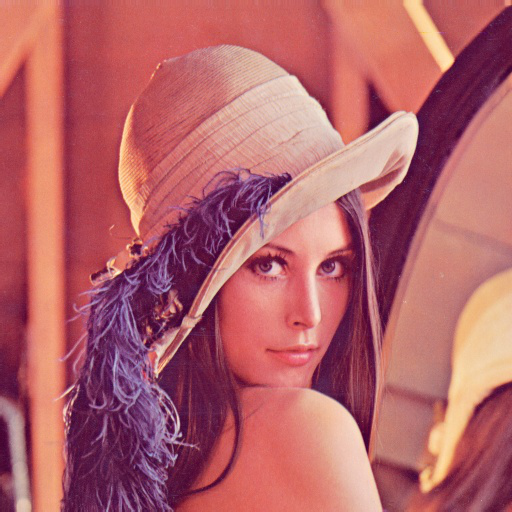

In [13]:
path = '/content/drive/MyDrive/Study/2ima35/lena.jpg'
image = Image.open(path)
display(image)

In [14]:
data = np.asarray(image)
flattened_data = data.copy().reshape(data.shape [0] * data.shape [1], data.shape [2])
print(data.shape)
print(flattened_data.shape)

(512, 512, 3)
(262144, 3)


### Determine k

In [ ]:
num_clusters = [2, 4, 8, 16, 32]

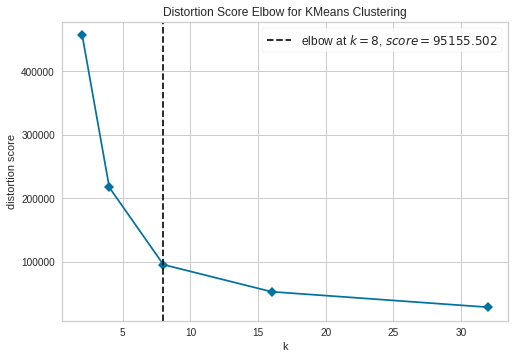

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbbac10ad00>,
                 estimator=KMeans(n_clusters=32, random_state=12),
                 k=[2, 4, 8, 16, 32], timings=False)

In [ ]:
kelbow_visualizer(KMeans(random_state=12), X, k=num_clusters, timings=False)

### Image segmentation

#### Varying number of clusters

In [ ]:
num_clusters = [2, 4, 8, 16, 32]
epsilon = 0.1

k=2


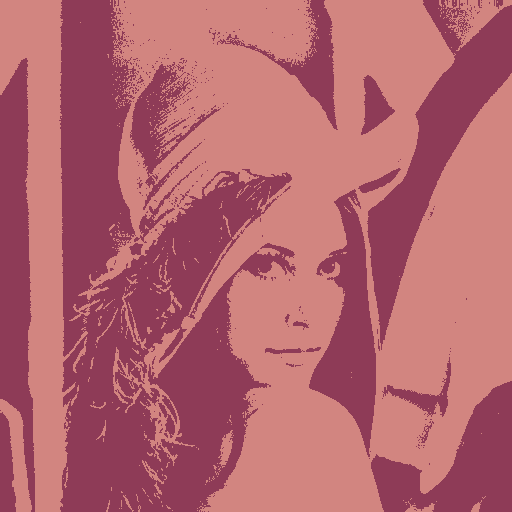

k=4


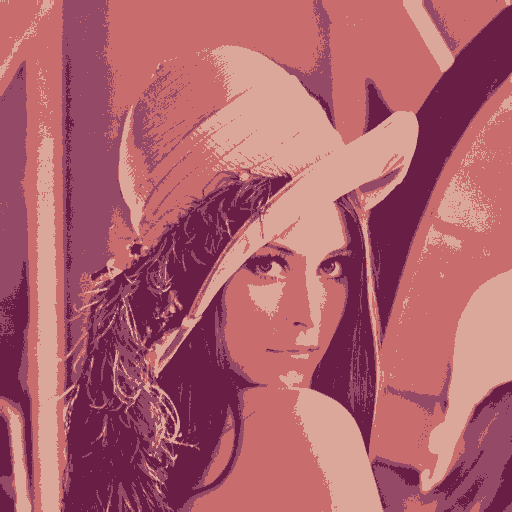

k=8


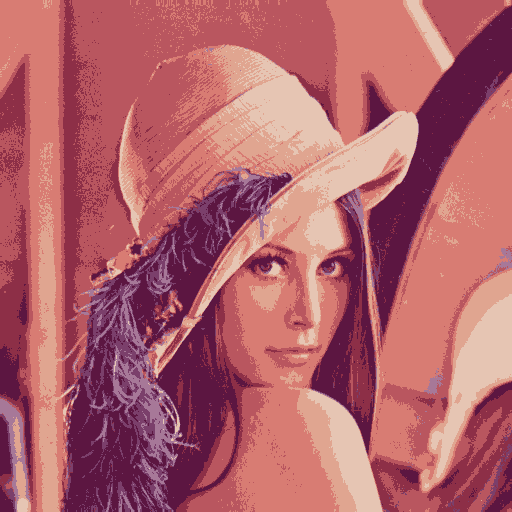

k=16


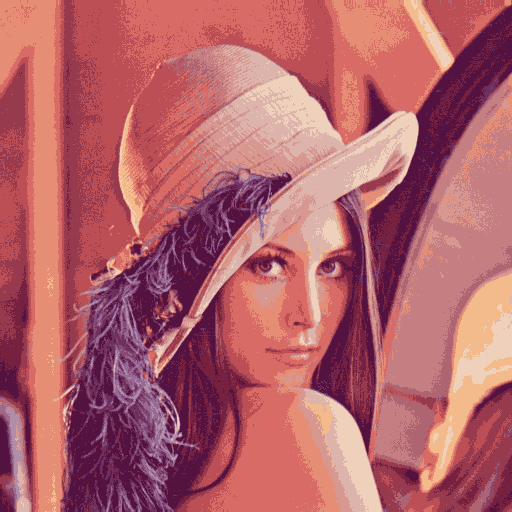

k=32


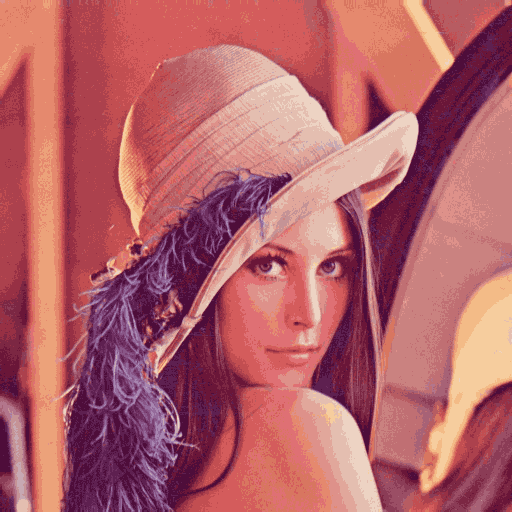

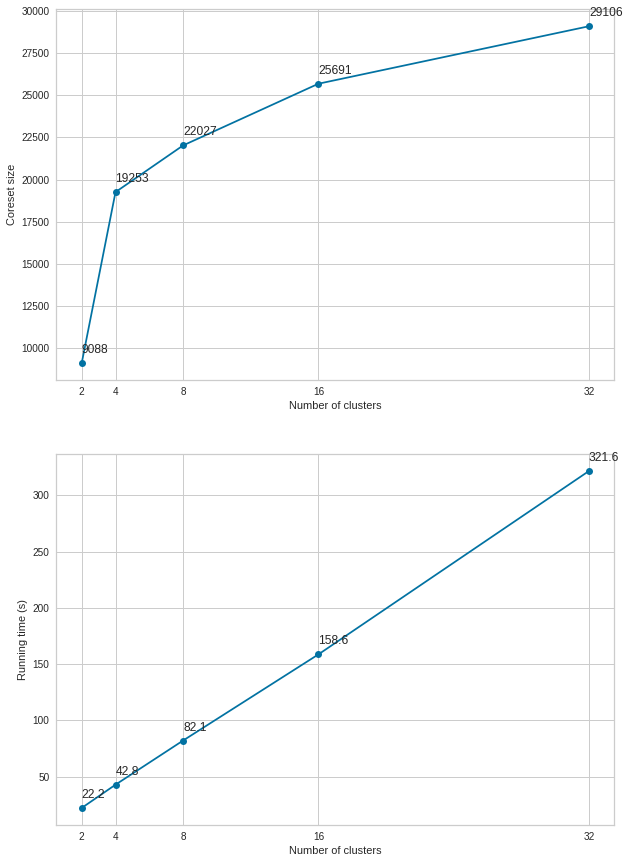

In [ ]:
coreset_sizes = []
running_times = []

for k in num_clusters:
    print(f"k={k}")
    coreset, coreset_construction_time = coreset_construction_mpc(flattened_data, k, epsilon, num_partitions=2, return_time=True)
    centroids, _, k_means_on_coreset_time = k_means_clustering(coreset, k, return_time=True)
    labels, compute_labels_time = compute_labels(flattened_data, centroids, return_time=True)

    coreset_sizes.append(len(coreset))
    running_times.append(coreset_construction_time + k_means_on_coreset_time + compute_labels_time)

    centroids = np.uint8(centroids) 
    segmented_data = centroids[labels].reshape(data.shape)
    segmented_image = Image.fromarray(segmented_data, 'RGB')
    display(segmented_image)

fig, axes = plt.subplots(2, figsize=(10, 10))

axes[0].plot(num_clusters, coreset_sizes, marker='o')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Coreset size')
axes[0].set_xticks(num_clusters)

for x, y in zip(num_clusters, coreset_sizes):
    axes[0].annotate(y, (x, y), textcoords="offset points", xytext=(0, 10))

axes[1].plot(num_clusters, running_times, marker='o')
axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Running time (s)')
axes[1].set_xticks(num_clusters)

for x, y in zip(num_clusters, running_times):
    axes[1].annotate(round(y, 1), (x, y), textcoords="offset points", xytext=(0, 10))

plt.show()

#### Varying number of clusters++

In [15]:
num_clusters = [256, 512, 1024]
epsilon = 0.1

In [ ]:
coreset_sizes = []
running_times = []

for k in num_clusters:
    print(f"k={k}")
    coreset, coreset_construction_time = coreset_construction_mpc(flattened_data, k, epsilon, num_partitions=2, return_time=True)
    centroids, _, k_means_on_coreset_time = k_means_clustering(coreset, k, return_time=True)
    labels, compute_labels_time = compute_labels(flattened_data, centroids, return_time=True)

    coreset_sizes.append(len(coreset))
    running_times.append(coreset_construction_time + k_means_on_coreset_time + compute_labels_time)

    centroids = np.uint8(centroids) 
    segmented_data = centroids[labels].reshape(data.shape)
    segmented_image = Image.fromarray(segmented_data, 'RGB')
    display(segmented_image)

fig, axes = plt.subplots(2, figsize=(10, 10))

axes[0].plot(num_clusters, coreset_sizes, marker='o')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Coreset size')
axes[0].set_xticks(num_clusters)

for x, y in zip(num_clusters, coreset_sizes):
    axes[0].annotate(y, (x, y), textcoords="offset points", xytext=(0, 10))

axes[1].plot(num_clusters, running_times, marker='o')
axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Running time (s)')
axes[1].set_xticks(num_clusters)

for x, y in zip(num_clusters, running_times):
    axes[1].annotate(round(y, 1), (x, y), textcoords="offset points", xytext=(0, 10))

plt.show()

k=256


#### Varying epsilon

In [ ]:
k = 8
epsilons = [0.1, 0.25, 0.5, 0.75, 1.0]

epsilon=0.1


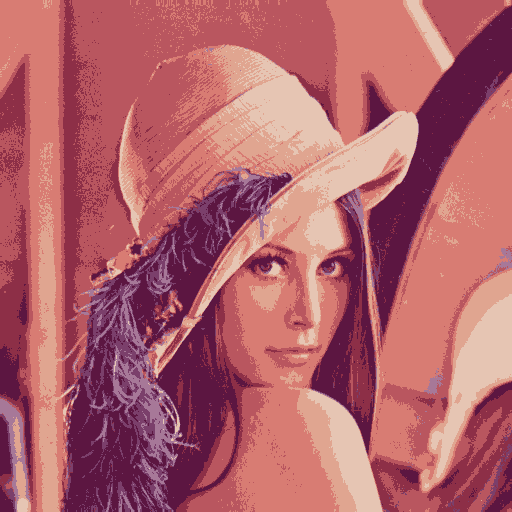

epsilon=0.25


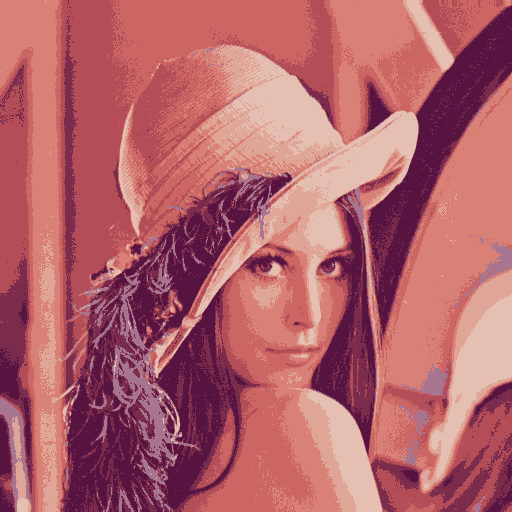

epsilon=0.5


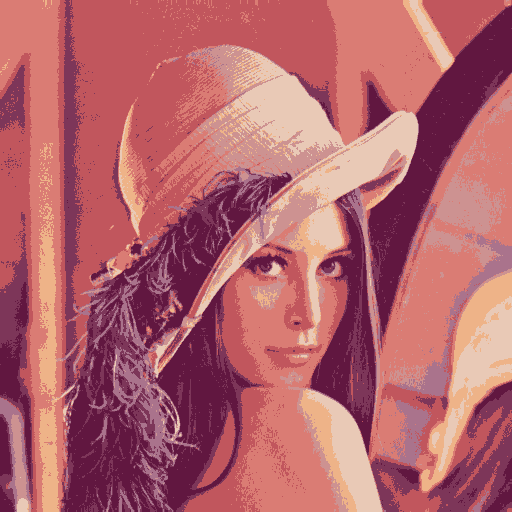

epsilon=0.75


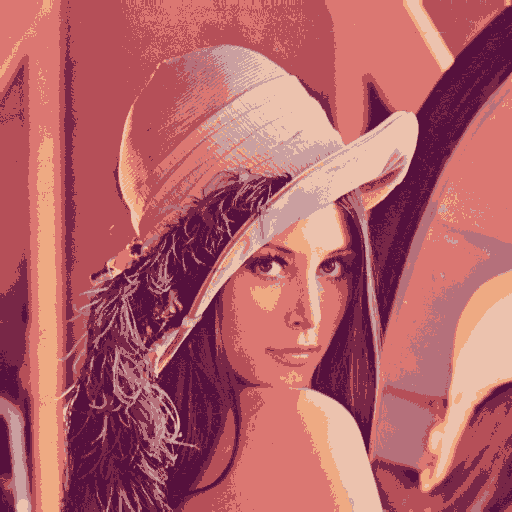

epsilon=1.0


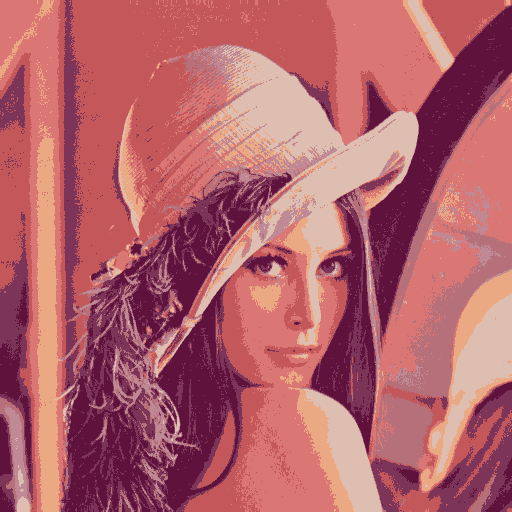

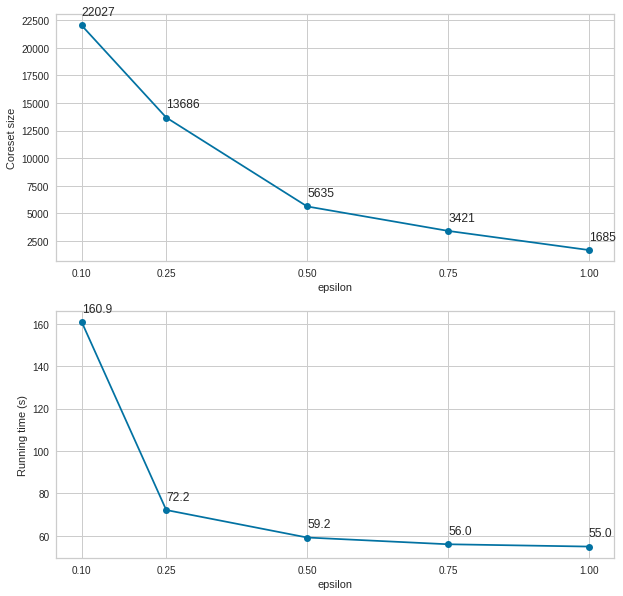

In [ ]:
coreset_sizes = []
running_times = []

for epsilon in epsilons:
    print(f"epsilon={epsilon}")
    coreset, coreset_construction_time = coreset_construction_mpc(flattened_data, k, epsilon, num_partitions=2, return_time=True)
    centroids, _, k_means_on_coreset_time = k_means_clustering(coreset, k, return_time=True)
    labels, compute_labels_time = compute_labels(flattened_data, centroids, return_time=True)

    coreset_sizes.append(len(coreset))
    running_times.append(coreset_construction_time + k_means_on_coreset_time + compute_labels_time)

    centroids = np.uint8(centroids) 
    segmented_data = centroids[labels].reshape(data.shape)
    segmented_image = Image.fromarray(segmented_data, 'RGB')
    display(segmented_image)

fig, axes = plt.subplots(2, figsize=(10, 10))

axes[0].plot(epsilons, coreset_sizes, marker='o')
axes[0].set_xlabel('epsilon')
axes[0].set_ylabel('Coreset size')
axes[0].set_xticks(epsilons)

for x, y in zip(epsilons, coreset_sizes):
    axes[0].annotate(y, (x, y), textcoords="offset points", xytext=(0, 10))

axes[1].plot(epsilons, running_times, marker='o')
axes[1].set_xlabel('epsilon')
axes[1].set_ylabel('Running time (s)')
axes[1].set_xticks(epsilons)

for x, y in zip(epsilons, running_times):
    axes[1].annotate(round(y, 1), (x, y), textcoords="offset points", xytext=(0, 10))

plt.show()

In [ ]:
sc.stop()